In [42]:
import pandas as pd
import numpy as np
import tensorflow.keras as keras

from seaborn import heatmap

from keras import Input
from keras import backend as K
from keras import regularizers, optimizers
from keras.layers import Dense, Dropout, ConvLSTM2D, Conv1D, \
AveragePooling1D, LSTM, GRU
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, \
roc_auc_score, plot_precision_recall_curve, plot_roc_curve, \
plot_confusion_matrix, confusion_matrix

from imblearn.over_sampling import SMOTENC

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

try:
    from src.functions import add_model, test_model, get_timeseries_table
except:
    from functions import add_model, test_model, get_timeseries_table

The below is thanks to [dokondr](https://stackoverflow.com/questions/45411902/how-to-use-f1-score-with-keras-model)

In [7]:
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [8]:
df = get_timeseries_table(prediction_window=135, 
                          binary_labels=True, 
                          one_hot_modules=True)
df

,assess_submitted_1,assess_score_1,assess_submitted_2,assess_score_2,assess_submitted_3,assess_score_3,assess_submitted_4,assess_score_4,assess_submitted_5,assess_score_5,assess_submitted_6,assess_score_6,assess_submitted_7,assess_score_7,assess_submitted_8,assess_score_8,sum_activities_-25,sum_click_-25,activities_x_clicks_-25,sum_activities_-24,sum_click_-24,activities_x_clicks_-24,sum_activities_-23,sum_click_-23,activities_x_clicks_-23,sum_activities_-22,sum_click_-22,activities_x_clicks_-22,sum_activities_-21,sum_click_-21,activities_x_clicks_-21,sum_activities_-20,sum_click_-20,activities_x_clicks_-20,sum_activities_-19,sum_click_-19,activities_x_clicks_-19,sum_activities_-18,sum_click_-18,activities_x_clicks_-18,...,sum_click_124,activities_x_clicks_124,sum_activities_125,sum_click_125,activities_x_clicks_125,sum_activities_126,sum_click_126,activities_x_clicks_126,sum_activities_127,sum_click_127,activities_x_clicks_127,sum_activities_128,sum_click_128,activities_x_clicks_128,sum_activities_129,sum_click_129,activities_x_clicks_129,sum_activities_130,sum_click_130,activities_x_clicks_130,sum_activities_131,sum_click_131,activities_x_clicks_131,sum_activities_132,sum_click_132,activities_x_clicks_132,sum_activities_133,sum_click_133,activities_x_clicks_133,sum_activities_134,sum_click_134,activities_x_clicks_134,final_result,module_AAA,module_BBB,module_CCC,module_DDD,module_EEE,module_FFF,module_GGG
registration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAA2013J11391,-1.0,78.0,-1.0,85.0,-2.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,13.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,42.0,210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0
AAA2013J28400,3.0,70.0,-2.0,68.0,4.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,23.0,253.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,38.0,418.0,0,1,0,0,0,0,0,0
AAA2013J31604,-2.0,72.0,-3.0,71.0,-2.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,10.0,51.0,510.0,0.0,0.0,0.0,6.0,19.0,114.0,5.0,16.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0
AAA2013J32885,7.0,69.0,21.0,30.0,7.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,162.0,5.0,8.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,9.0,18.0,2.0,9.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,0,1,0,0,0,0,0,0
AAA2013J38053,0.0,79.0,10.0,69.0,0.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,4.0,8.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,9.0,36.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGG2014J691787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1
GGG2014J692171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [9]:
X = df.drop(columns='final_result')
y = df['final_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111, test_size=.1)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=111, test_size=.1)

In [34]:
len(X.columns)

503

In [39]:
categoricals = [502, 501, 500, 499, 498, 497, 496]
smotenc = SMOTENC(categoricals, random_state=111)
os_X_train, os_y_train = smotenc.fit_resample(X_train, y_train)
os_X_t, os_y_t = smotenc.fit_resample(X_t, y_t)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [10]:
l1 = 1e-4
l2 = 1e-3
bias = 1e-4
dropout500=0.4
dropout300=0.2
dropout200=0.2

model1 = keras.Sequential()
model1.add(Input((X.shape[1])))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))

model1.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adamax()

model1.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

#class_balance = num(pass) / num(fail).  Use this to weight class 0.
class_balance = sum(y_t == 1) / sum(y_t == 0)

model1.fit(X_t, y_t,
           batch_size = 200,
           epochs = 50,
           validation_data=(X_val, y_val),
        #    class_weight = {1: 1.0,
        #                    0: class_balance}
           )

Epoch 1/50
98/98 [==============================] - 5s 15ms/step - loss: 14.8957 - accuracy: 0.6078 - val_loss: 13.8702 - val_accuracy: 0.6654
Epoch 2/50
98/98 [==============================] - 1s 9ms/step - loss: 13.6850 - accuracy: 0.6397 - val_loss: 13.2830 - val_accuracy: 0.6784
Epoch 3/50
98/98 [==============================] - 1s 9ms/step - loss: 13.1219 - accuracy: 0.6378 - val_loss: 12.8057 - val_accuracy: 0.6789
Epoch 4/50
98/98 [==============================] - 1s 9ms/step - loss: 12.6538 - accuracy: 0.6522 - val_loss: 12.3774 - val_accuracy: 0.6090
Epoch 5/50
98/98 [==============================] - 1s 9ms/step - loss: 12.2203 - accuracy: 0.6783 - val_loss: 11.9652 - val_accuracy: 0.5405
Epoch 6/50
98/98 [==============================] - 1s 9ms/step - loss: 11.8109 - accuracy: 0.6757 - val_loss: 11.5548 - val_accuracy: 0.5280
Epoch 7/50
98/98 [==============================] - 1s 9ms/step - loss: 11.3954 - accuracy: 0.6847 - val_loss: 11.1492 - val_accuracy: 0.5164
Epoch

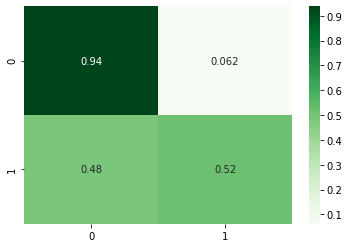

In [30]:
yhat = np.around(model1.predict(X_val)).astype(int)[:,0]

confusion = confusion_matrix(y_val, yhat, normalize='true')
heatmap(confusion, cmap='Greens', annot=True)

In [52]:
l1 = 1e-4
l2 = 1e-3
bias = 1e-4
dropout500=0.4
dropout300=0.2
dropout200=0.2

model1 = keras.Sequential()
model1.add(Input((X.shape[1])))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))

model1.add(Dense(1, activation='sigmoid'))

# optimizer = optimizers.SGD(learning_rate=.1)
optimizer = keras.optimizers.Adam(learning_rate = .001)

model1.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

class_balance = sum(y_t == 1) / sum(y_t == 0)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

model1.fit(os_X_t, os_y_t,
           batch_size = 200,
           epochs = 50,
           validation_data=(X_val, y_val),
           callbacks = [reduce_lr]
           )

Epoch 1/50
125/125 [==============================] - 4s 13ms/step - loss: 14.4721 - accuracy: 0.5726 - val_loss: 11.3858 - val_accuracy: 0.4419
Epoch 2/50
125/125 [==============================] - 1s 9ms/step - loss: 10.5479 - accuracy: 0.6366 - val_loss: 8.5340 - val_accuracy: 0.6599
Epoch 3/50
125/125 [==============================] - 1s 8ms/step - loss: 7.8429 - accuracy: 0.7307 - val_loss: 6.2508 - val_accuracy: 0.7635
Epoch 4/50
125/125 [==============================] - 1s 8ms/step - loss: 5.7749 - accuracy: 0.7495 - val_loss: 4.6747 - val_accuracy: 0.6988
Epoch 5/50
125/125 [==============================] - 1s 8ms/step - loss: 4.2385 - accuracy: 0.7664 - val_loss: 3.4261 - val_accuracy: 0.7367
Epoch 6/50
125/125 [==============================] - 1s 8ms/step - loss: 3.1470 - accuracy: 0.7631 - val_loss: 2.5863 - val_accuracy: 0.7469
Epoch 7/50
125/125 [==============================] - 1s 8ms/step - loss: 2.3772 - accuracy: 0.7695 - val_loss: 1.9775 - val_accuracy: 0.7649
Ep

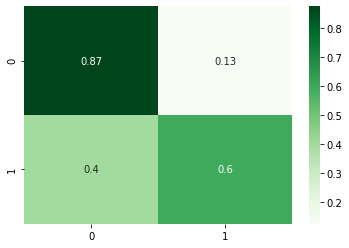

In [53]:
yhat = np.around(model1.predict(X_val)).astype(int)[:,0]

confusion = confusion_matrix(y_val, yhat, normalize='true')
heatmap(confusion, cmap='Greens', annot=True)